In [39]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/hin/Documents/St_Andrews/dense_basis')
import dense_basis as db

from george import kernels
import george
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)

from scipy.optimize import minimize

# Background
The aim of this experiment is to take Yirui's "true" SFH, bin it under non parametric SFH schemes to simulate a posterior sample from fitting the galaxy's spectrum, then test which scheme of NP SFH best recreates the SFH of a PSB best with few enough bins. Of course actual fitting from the spectrum will be much more complicated and I am fitting the true SFH here directly, but this should give us some idea of how the different schemes behave given this one SFH of a PSB.

First copy-pasted functions from dense_basis's gp-sfh part

In [848]:
def nll(p, gp, y):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_nll(p, gp, y):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

def gp_interpolator(x,y,res = 1000, Nparam = 3, decouple_sfr = False, var=False, sample=False):

    yerr = np.zeros_like(y)
    yerr[2:(2+Nparam)] = 0.001/np.sqrt(Nparam)
    if len(yerr) > 26:
        yerr[2:(2+Nparam)] = 0.1/np.sqrt(Nparam)
    yerr[(2+Nparam):] = 0.1
    #kernel = np.var(y) * kernels.ExpSquaredKernel(np.median(y))
    #kernel = np.var(y) * kernels.LinearKernel(np.median(y),order=1)
    #kernel = np.var(y) * kernels.Matern32Kernel(np.median(y)) #+ k2
    kernel = np.var(y) * (kernels.Matern32Kernel(np.median(y)) + kernels.LinearKernel(np.median(y), order=2))
    gp = george.GP(kernel, solver=george.HODLRSolver)

    #print(xax.shape, yerr.shape)
    gp.compute(x.ravel(), yerr.ravel())
    
    # optimize kernel parameters
    #p0 = gp.get_parameter_vector()
    #results = minimize(nll, p0, jac=grad_nll, method="L-BFGS-B", args = (gp, y))
    #print(results)
    #gp.set_parameter_vector(results.x)

    x_pred = np.linspace(np.amin(x), np.amax(x), res)
    y_pred, pred_var = gp.predict(y.ravel(), x_pred, return_var=True)
    
    if var==True:
        if sample==True:
            samples = gp.sample_conditional(y.ravel(), x_pred, size=10)
            return x_pred, y_pred, pred_var, samples
        else:
            return x_pred, y_pred, pred_var
    else:
        return x_pred, y_pred

def treat_sfh(time_arr_interp, mass_arr_interp, sfh_tuple, zval, 
              decouple_sfr, decouple_sfr_time, sfr_tolerance, pred_var=None):
    sfh = (np.diff(mass_arr_interp)*10**(sfh_tuple[0])) / (np.diff(time_arr_interp)*cosmo.age(zval).value*1e9)
    #sfh_scale = 10**(sfh_tuple[0])/(cosmo.age(zval).value*1e9/1000)
    #sfh = np.diff(mass_arr_interp)*sfh_scale
    sfh[sfh<0] = 0
    sfh = np.insert(sfh,0,[0])
    if pred_var is not None:
        sfh_var = (pred_var[1:]+pred_var[:-1]) * (10**(sfh_tuple[0])/(np.diff(time_arr_interp)*cosmo.age(zval).value*1e9))**2
        sfh_var = np.insert(sfh_var,0,[0])
    
    sfr_decouple_time_index = np.argmin(np.abs(time_arr_interp*cosmo.age(zval).value - decouple_sfr_time/1e3))
    if sfr_decouple_time_index == 0:
        sfr_decouple_time_index = 2
    mass_lastbins = np.trapz(x=time_arr_interp[-sfr_decouple_time_index:]*1e9*(cosmo.age(zval).value), y=sfh[-sfr_decouple_time_index:])
    mass_remaining = 10**(sfh_tuple[0]) - mass_lastbins
    if mass_remaining < 0:
        mass_remaining = 0
        print('input SFR, M* combination is not physically consistent (log M*: %.2f, log SFR: %.2f.)' %(sfh_tuple[0],sfh_tuple[1]))
    mass_initbins = np.trapz(x=time_arr_interp[0:(1000-sfr_decouple_time_index)]*1e9*(cosmo.age(zval).value), y=sfh[0:(1000-sfr_decouple_time_index)])
    sfh[0:(1000-sfr_decouple_time_index)] = sfh[0:(1000-sfr_decouple_time_index)] * mass_remaining / mass_initbins
    
    if (np.abs(np.log10(sfh[-1]) - sfh_tuple[1]) > sfr_tolerance) or (decouple_sfr == True):
        sfh[-sfr_decouple_time_index:] = 10**sfh_tuple[1]
    
#     if decouple_sfr == True:
#         sfr_decouple_time_index = np.argmin(np.abs(time_arr_interp*cosmo.age(zval).value - decouple_sfr_time/1e3))
#         sfh[-sfr_decouple_time_index:] = 10**sfh_tuple[1]
    if pred_var is not None:
        return sfh, sfh_var
    else: return sfh
    
    
def tuple_to_sfh(sfh_tuple, zval, interpolator = 'gp_george', decouple_sfr = False, decouple_sfr_time = 10, sfr_tolerance = 0.05, vb = False,cosmo = cosmo):
    # generate an SFH from an input tuple (Mass, SFR, {tx}) at a specified redshift


    Nparam = int(sfh_tuple[2])
    mass_quantiles = np.linspace(0,1,Nparam+2)
    time_quantiles = np.zeros_like(mass_quantiles)
    time_quantiles[-1] = 1
    time_quantiles[1:-1] = sfh_tuple[3:]
    
    if vb == True:
        print('pre-adjustment:',time_quantiles, mass_quantiles)

    # now add SFR constraints

    # SFR smoothly increasing from 0 at the big bang
    mass_quantiles = np.insert(mass_quantiles,1,[0.00])
    time_quantiles = np.insert(time_quantiles,1,[0.01])

    # SFR constrained to SFR_inst at the time of observation
    #SFH_constraint_percentiles = np.array([0.96,0.97,0.98,0.99])
    SFH_constraint_percentiles = np.array([0.97, 0.98, 0.99])
    for const_vals in SFH_constraint_percentiles:

        delta_mstar = 10**(sfh_tuple[0]) *(1-const_vals)
        delta_t = 1 - delta_mstar/(10**sfh_tuple[1])/(cosmo.age(zval).value*1e9)
        if vb == True:
            print(delta_t,time_quantiles[-2])

        if (delta_t > time_quantiles[-2]) & (delta_t > 0.9):
            if vb == True:
                print('if', const_vals)
            mass_quantiles = np.insert(mass_quantiles, -1, [const_vals], )
            time_quantiles = np.insert(time_quantiles, -1, [delta_t],)
        else:
            if vb == True:
                print('else', const_vals)
            if const_vals > time_quantiles[-2]:
                delta_m = 1 - ((cosmo.age(zval).value*1e9)*(1-const_vals)*(10**sfh_tuple[1]))/(10**sfh_tuple[0])
                time_quantiles = np.insert(time_quantiles, -1, [const_vals])
                mass_quantiles=  np.insert(mass_quantiles, -1, [delta_m])
    
    if vb == True:
        print('post-adjustment:',time_quantiles, mass_quantiles)
    
    if interpolator == 'gp_george':
        time_arr_interp, mass_arr_interp, pred_var, mass_arr_interp_samples = gp_interpolator(
            time_quantiles, mass_quantiles, Nparam = int(Nparam), decouple_sfr = decouple_sfr, 
            var=True, sample=True)
    elif interpolator == 'gp_sklearn':
        time_arr_interp, mass_arr_interp = gp_sklearn_interpolator(time_quantiles, mass_quantiles)
    elif interpolator == 'linear':
        time_arr_interp, mass_arr_interp = linear_interpolator(time_quantiles, mass_quantiles)
    elif interpolator == 'pchip':
        time_arr_interp, mass_arr_interp = Pchip_interpolator(time_quantiles, mass_quantiles)
    else:
        raise Exception('specified interpolator does not exist: {}. \n use one of the following: gp_george, gp_sklearn, linear, and pchip '.format(interpolator))
    
    sfh, sfh_var = treat_sfh(time_arr_interp, mass_arr_interp, sfh_tuple, zval, 
                             decouple_sfr, decouple_sfr_time, sfr_tolerance, pred_var=pred_var)
    
    samp = []
    for i,sample in enumerate(mass_arr_interp_samples):
        sfh_i = treat_sfh(time_arr_interp, sample, sfh_tuple, zval, 
                             decouple_sfr, decouple_sfr_time, sfr_tolerance)
        samp.append([sfh_i, sample])

    timeax = time_arr_interp * cosmo.age(zval).value

    if vb == True:
        print('time and mass quantiles:')
        print(time_quantiles, mass_quantiles)
        plt.plot(time_quantiles, mass_quantiles,'--o')
        plt.plot(time_arr_interp, mass_arr_interp)
        plt.axis([0,1,0,1])
        #plt.axis([0.9,1.05,0.9,1.05])
        plt.show()

        print('instantaneous SFR: %.1f' %sfh[-1])
        plt.plot(np.amax(time_arr_interp) - time_arr_interp, sfh)
        #plt.xscale('log')
        plt.show()

    return sfh, timeax, mass_arr_interp, sfh_var, pred_var, samp

Loading in the true SFH and calculating important variables

In [662]:
plt.rcParams.update({'font.size': 14})

sim_data = np.loadtxt('../Yirui_test_cube/snap119/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_snap119_SFH_at_diff_radius.txt')
age_at_z = cosmo.age(0.04).value
model_lb_time = sim_data[:,0]
model_ages = age_at_z - model_lb_time
mask = model_ages > 0
model_ages = model_ages[mask][::-1]
model_sfh = sim_data[:,2][mask][::-1]
model_lb_time = model_lb_time[mask][::-1]
model_Mstar = np.trapz(y=model_sfh, x=model_ages)*10**9

#cumulative mass formed vs age
Mstar_total_model = np.trapz(model_sfh, x=model_ages)
c_model_sfh = np.zeros(len(model_sfh))
for i,sfh in enumerate(model_sfh):
    c_model_sfh[i] = np.trapz(model_sfh[:i+1],x=model_ages[:i+1])/Mstar_total_model

# Iyer2019's method of binning
Binning the true SFH using iyer's method (equal mass in each bin with adaptive bin boundaries) and calculate the resulting tx

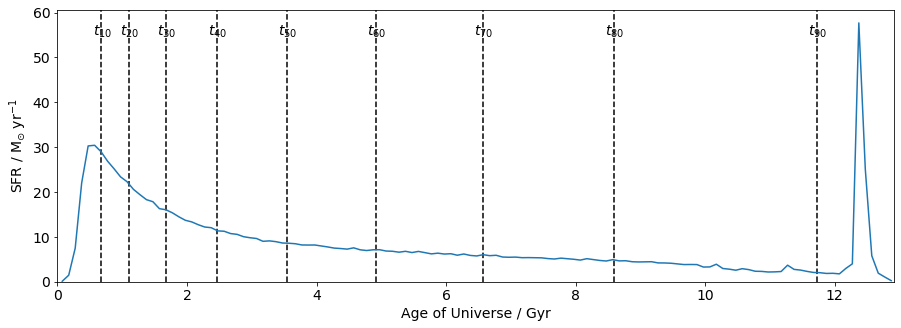

In [817]:
def bin_iyer(Nbins):
    total_mass = np.trapz(y=model_sfh, x=model_ages)
    c_mass = []
    for i,sfh in enumerate(model_sfh):
        c_mass.append(np.trapz(y=model_sfh[:i+1], x=model_ages[:i+1])/total_mass)
    mass_percentiles = np.arange(1,Nbins)*1/Nbins
    tx = np.interp(mass_percentiles, c_mass, model_ages/age_at_z)
    return np.array(tx)

Nbins = 10
tx = bin_iyer(Nbins)

fig, ax = plt.subplots(figsize=[15,5])
ax.plot(model_ages, model_sfh)
ax.set_xlim([0,age_at_z])
ax.set_xlabel('Age of Universe / Gyr')
ax.set_ylabel(r'SFR / $\rm{M_{\odot}}\; \rm{yr}^{-1}$')
ylims = ax.get_ylim()
ax.vlines(tx*age_at_z, 0, ylims[1], color='k', ls='--')
for i,txi in enumerate(tx):
    ax.annotate('$t_{'+str(int((i+1)*100/Nbins))+'}$', [(txi-0.01)*age_at_z, 0.95*max(model_sfh)])
ax.set_ylim([0,ylims[1]])
plt.show()

Fitting the calculated tx values with GP to attempt to recreate the true SFH

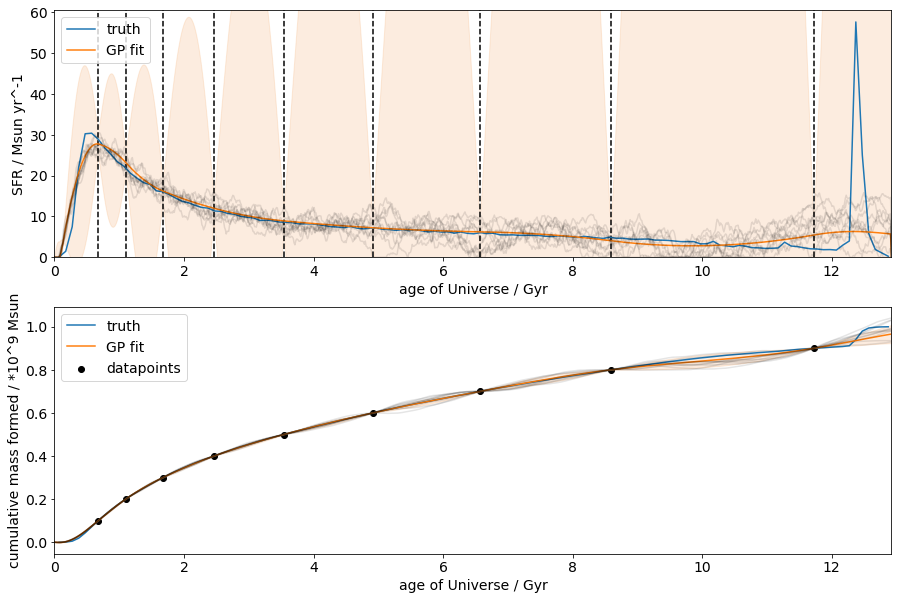

In [850]:
def db_fit(Nbins, tx):
    iyer_param = np.hstack([np.log10(model_Mstar), np.log10(model_sfh[-1]), Nbins-1, tx])
    return tuple_to_sfh(iyer_param, 0.04, vb=False)

iyer_sfh, iyer_ages, iyer_c_mass, iyer_sfh_var, iyer_c_mass_var, iyer_samples = db_fit(Nbins, tx)
fig, ax = plt.subplots(2, 1, figsize=[15,10])
ax[0].plot(model_ages, model_sfh, label='truth')
ylims = ax[0].get_ylim()
ax[0].vlines(tx*age_at_z, 0, ylims[1], color='k', ls='--')
ax[0].plot(iyer_ages, iyer_sfh, label='GP fit')
ax[0].fill_between(iyer_ages, iyer_sfh-np.sqrt(iyer_sfh_var), iyer_sfh+np.sqrt(iyer_sfh_var), 
                  color='sandybrown', alpha=0.2)
ax[0].set_xlim([0,age_at_z])
ax[0].set_ylim([0,ylims[1]])
ax[0].set_xlabel('age of Universe / Gyr')
ax[0].set_ylabel('SFR / Msun yr^-1')
ax[0].legend()

ax[1].plot(model_ages, c_model_sfh, label='truth')
ax[1].scatter(tx*age_at_z, np.linspace(0,1,Nbins+1)[1:-1], color='k', label='datapoints')
ax[1].plot(iyer_ages, iyer_c_mass, label='GP fit')
ax[1].fill_between(iyer_ages, iyer_c_mass-np.sqrt(iyer_c_mass_var), iyer_c_mass+np.sqrt(iyer_c_mass_var), 
                  color='sandybrown', alpha=0.2)
ax[1].set_xlim([0,age_at_z])
ax[1].set_xlabel('age of Universe / Gyr')
ax[1].set_ylabel('cumulative mass formed / *10^9 Msun')
for samp in iyer_samples:
    ax[0].plot(iyer_ages, samp[0], color='k', alpha=0.1)
    ax[1].plot(iyer_ages, samp[1], color='k', alpha=0.1)
ax[1].legend()
plt.show()

What if for higher number of bins?

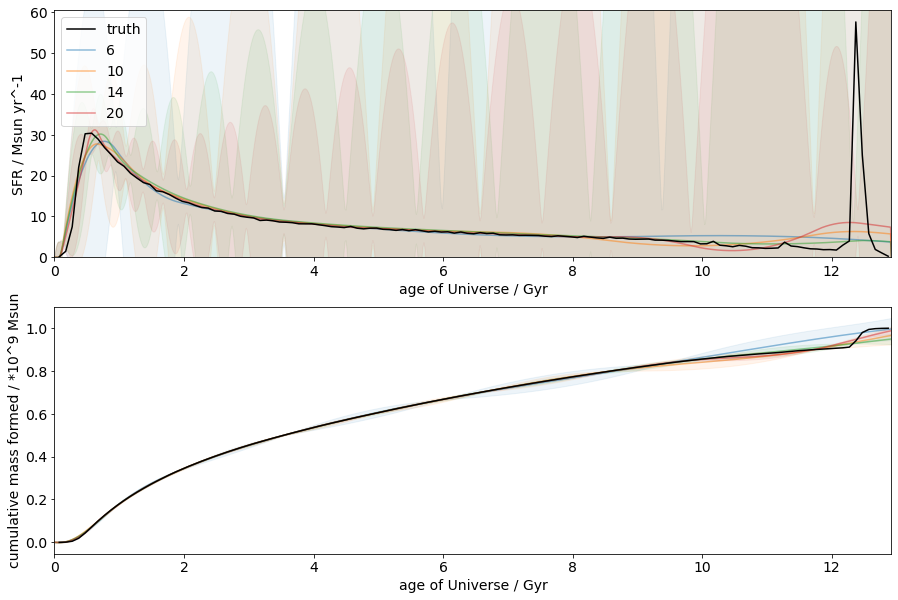

In [779]:
fig, ax = plt.subplots(2,1,figsize=[15,10])
ax[0].plot(model_ages, model_sfh, label='truth', zorder=4, color='k')
ylims = ax[0].get_ylim()
ax[1].plot(model_ages, c_model_sfh, label='truth', zorder=4, color='k')
for Nbins in [6,10,14,20]:
    tx = bin_iyer(Nbins)
    iyer_sfh, iyer_ages, iyer_c_mass, iyer_sfh_var, iyer_c_mass_var, iyer_samples = db_fit(Nbins, tx)
    p1 = ax[0].plot(iyer_ages, iyer_sfh, label=Nbins, alpha=0.5)
    ax[0].fill_between(iyer_ages, iyer_sfh-np.sqrt(iyer_sfh_var), iyer_sfh+np.sqrt(iyer_sfh_var), 
                  color=p1[0].get_color(), alpha=0.08)
    p2 = ax[1].plot(iyer_ages, iyer_c_mass, label=Nbins, alpha=0.5)
    ax[1].fill_between(iyer_ages, iyer_c_mass-np.sqrt(iyer_c_mass_var), iyer_c_mass+np.sqrt(iyer_c_mass_var), 
                  color=p2[0].get_color(), alpha=0.08)
ax[0].set_xlim([0,age_at_z])
ax[0].set_ylim([0, ylims[1]])
ax[0].set_xlabel('age of Universe / Gyr')
ax[0].set_ylabel('SFR / Msun yr^-1')
ax[0].legend()
ax[1].set_xlim([0,age_at_z])
ax[1].set_xlabel('age of Universe / Gyr')
ax[1].set_ylabel('cumulative mass formed / *10^9 Msun')
plt.show()

Comments:

Ok, even with just 6 bins with Iyer's method is able to capture the curve in early-formation quite well, but the starburst can never be recreated, not even with 20 bins.

# Uniform bin width in log time
Alternative binning scheme proposed by Vivienne: to definie bin boundaries as uniform width in log lookback time, and fit for the mass formed in each bin

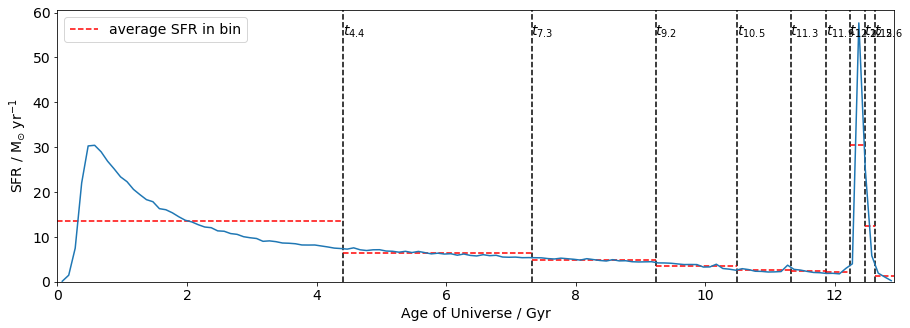

In [862]:
def bin_logtime(Nbins, interp=True, begin_time=3*10**8, end_time=None):
    # begin_time and end_time are the two extremes at which the bin boundaries are linspaced between
    # Note that they are in lookback time instead of age
    if end_time == None:
        end_time = age_at_z*10**9
    logtime_per_bin = (np.log10(end_time)-np.log10(begin_time))/(Nbins-1)
    tx = age_at_z - 10**(np.arange(Nbins-1)*logtime_per_bin + np.log10(begin_time) - 9)
    tx = tx[::-1]
    
    mass_so_far = [0]
    for txi in tx:
        if interp==True:
            sfh_at_txi = np.interp(txi, model_ages, model_sfh)
            insert_index = model_ages.searchsorted(txi)
            model_ages_ = np.insert(model_ages,insert_index,txi)
            model_sfh_ = np.insert(model_sfh,insert_index,sfh_at_txi)
            int_mass = np.trapz(y=model_sfh_[model_ages_<=txi], x=model_ages_[model_ages_<=txi]*10**9)
        else:
            int_mass = np.trapz(y=model_sfh[model_ages<=txi], x=model_ages[model_ages<=txi]*10**9)
        mass_so_far.append(int_mass)
    #mass_so_far.append(np.trapz(y=model_sfh, x=model_ages*10**9))
    mass_so_far = np.array(mass_so_far)
    mass_formed = mass_so_far[1:]-mass_so_far[:-1]
    t_mass_formed = np.trapz(y=model_sfh, x=model_ages*10**9)
    return tx/age_at_z, mass_formed/t_mass_formed

Nbins = 10
tx, f_mass_formed = bin_logtime(Nbins, interp=True, end_time=None)
tx_ = np.array([0,*tx, 1])*age_at_z
f_mass_formed_ = np.insert(f_mass_formed, len(f_mass_formed), 1-np.sum(f_mass_formed))
durations = abs(tx_[1:] - tx_[:-1])
sfrs = f_mass_formed_*np.trapz(y=model_sfh, x=model_ages*10**9)/durations/10**9

fig, ax = plt.subplots(figsize=[15,5])
ax.plot(model_ages, model_sfh)
ax.set_xlim([0,age_at_z])
ax.set_xlabel('Age of Universe / Gyr')
ax.set_ylabel(r'SFR / $\rm{M_{\odot}}\; \rm{yr}^{-1}$')
ylims = ax.get_ylim()
ax.vlines(tx*age_at_z, 0, ylims[1], color='k', ls='--')
ax.hlines(sfrs, tx_[:-1], tx_[1:], color='r', ls='--', label='average SFR in bin')

for i,txi in enumerate(tx):
    ax.annotate('$t_{'+str(np.round(txi*age_at_z,1))+'}$', [(txi*age_at_z-0.01), 0.95*max(model_sfh)])
ax.set_ylim([0,ylims[1]])
ax.legend()
plt.show()

A modification of dense_basis code to use GP to fit this new binning scheme

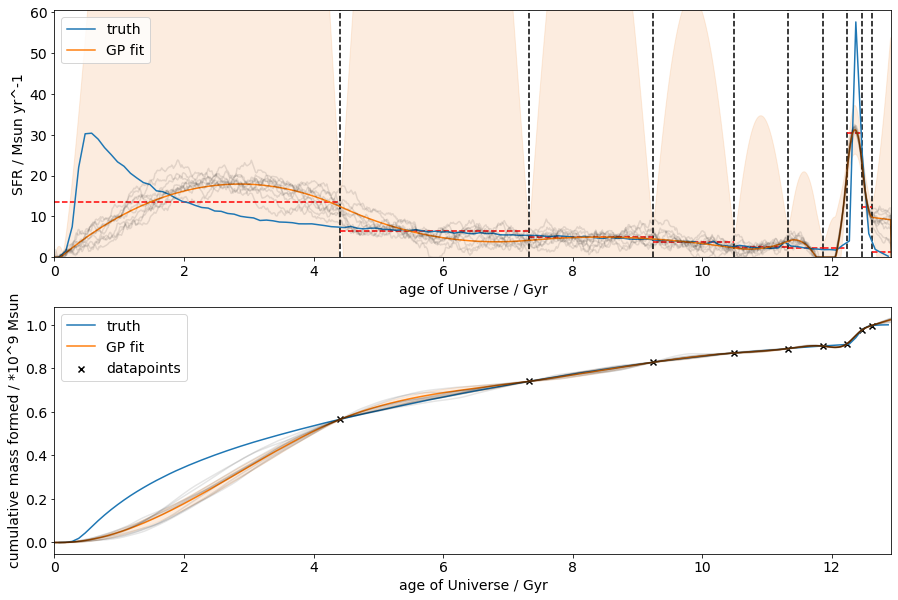

In [863]:
def fit_logtime(sfh_tuple, zval, interpolator = 'gp_george', decouple_sfr = False, 
                decouple_sfr_time = 10, sfr_tolerance = 0.05, vb = False,cosmo = cosmo):
    # sfh_tuple[0] = total mass formed in log10 form
    # sfh_tuple[1] = log10 SFR at time of observation
    # sfh_tuple[2] = list of time bin boundaries in fractions of the universe's current
    # sfh_tuple[3] = list of fraction mass formed at bin boundaries
    
    # generate an SFH from an input tuple at a specified redshift
    Nparam = int(sfh_tuple[2])
    input_tx = sfh_tuple[3:3+Nparam]
    input_mf = sfh_tuple[3+Nparam:3+2*Nparam]
    c_mass_formed = np.zeros(len(input_mf))
    for i,mi in enumerate(input_mf):
        c_mass_formed[i] = np.sum(input_mf[:i+1])
    mass_quantiles = np.array([0,*c_mass_formed,1])
    time_quantiles = np.zeros_like(mass_quantiles)
    time_quantiles[-1] = 1
    time_quantiles[1:-1] = input_tx
    
    if vb == True:
        print('pre-adjustment:',time_quantiles, mass_quantiles)
    
    # now add SFR constraints
    mass_quantiles = np.insert(mass_quantiles,1,[0.00])
    time_quantiles = np.insert(time_quantiles,1,[0.01])
    
    # SFR constrained to SFR_inst at the time of observation
    #SFH_constraint_percentiles = np.array([0.96,0.97,0.98,0.99])
    SFH_constraint_percentiles = np.array([0.97, 0.98, 0.99])
    for const_vals in SFH_constraint_percentiles:

        delta_mstar = 10**(sfh_tuple[0]) *(1-const_vals)
        delta_t = 1 - delta_mstar/(10**sfh_tuple[1])/(cosmo.age(zval).value*1e9)
        if vb == True:
            print(delta_t,time_quantiles[-2])

        if (delta_t > time_quantiles[-2]) & (delta_t > 0.9):
            if vb == True:
                print('if', const_vals)
            mass_quantiles = np.insert(mass_quantiles, -1, [const_vals], )
            time_quantiles = np.insert(time_quantiles, -1, [delta_t],)
        else:
            if vb == True:
                print('else', const_vals)
            if const_vals > time_quantiles[-2]:
                delta_m = 1 - ((cosmo.age(zval).value*1e9)*(1-const_vals)*(10**sfh_tuple[1]))/(10**sfh_tuple[0])
                time_quantiles = np.insert(time_quantiles, -1, [const_vals])
                mass_quantiles=  np.insert(mass_quantiles, -1, [delta_m])
    
    #debug stuff
    if vb == True:
        print('post-adjustment:',time_quantiles, mass_quantiles)
        plt.plot(model_ages, c_model_sfh)
        plt.plot(time_quantiles*age_at_z, mass_quantiles*np.trapz(y=model_sfh, x=model_ages))
        plt.show()
        
    #transform 0-1 in linear tme to 0-1 in log lookback time
    #a = 1
    #time_quantiles_ = 1-np.log(a*((1-time_quantiles)+1)-(a-1))/np.log(a+1)
    #print(time_quantiles)
    #print(time_quantiles_)
    #time_quantiles = time_quantiles_.copy()
    
    if interpolator == 'gp_george':
        time_arr_interp, mass_arr_interp, pred_var, mass_arr_interp_samples = gp_interpolator(
            time_quantiles, mass_quantiles, Nparam = int(Nparam), decouple_sfr = decouple_sfr, 
            var=True, sample=True)
    elif interpolator == 'gp_sklearn':
        time_arr_interp, mass_arr_interp = gp_sklearn_interpolator(time_quantiles, mass_quantiles)
    elif interpolator == 'linear':
        time_arr_interp, mass_arr_interp = linear_interpolator(time_quantiles, mass_quantiles)
    elif interpolator == 'pchip':
        time_arr_interp, mass_arr_interp = Pchip_interpolator(time_quantiles, mass_quantiles)
    else:
        raise Exception('specified interpolator does not exist: {}. \n use one of the following: gp_george, gp_sklearn, linear, and pchip '.format(interpolator))
        
    #time_arr_interp_ = 1-((np.exp((1-time_arr_interp)*np.log(a+1))+(a-1))/a-1)
    #print(time_arr_interp)
    #print(time_arr_interp_)
    #time_arr_interp = time_arr_interp_.copy()
    
    sfh, sfh_var = treat_sfh(time_arr_interp, mass_arr_interp, sfh_tuple, zval, 
                             decouple_sfr, decouple_sfr_time, sfr_tolerance, pred_var=pred_var)
    
    samp = []
    for i,sample in enumerate(mass_arr_interp_samples):
        sfh_i = treat_sfh(time_arr_interp, sample, sfh_tuple, zval, 
                             decouple_sfr, decouple_sfr_time, sfr_tolerance)
        samp.append([sfh_i, sample])

    timeax = time_arr_interp * cosmo.age(zval).value

    if vb == True:
        print('time and mass quantiles:')
        print(time_quantiles, mass_quantiles)
        plt.plot(time_quantiles, mass_quantiles,'--o')
        plt.plot(time_arr_interp, mass_arr_interp)
        plt.axis([0,1,0,1])
        #plt.axis([0.9,1.05,0.9,1.05])
        plt.show()

        print('instantaneous SFR: %.1f' %sfh[-1])
        plt.plot(np.amax(time_arr_interp) - time_arr_interp, sfh)
        #plt.xscale('log')
        plt.show()

    return sfh, timeax, mass_arr_interp, sfh_var, pred_var, samp

def lt_fit(Nbins, tx, mf):
    lt_param = np.hstack([np.log10(model_Mstar), np.log10(model_sfh[-1]), Nbins-1, tx, mf])
    return fit_logtime(lt_param, 0.04, vb=False)

lt_sfh, lt_ages, lt_c_mass, lt_sfh_var, lt_c_mass_var, lt_samples = lt_fit(Nbins, tx, f_mass_formed)
fig, ax = plt.subplots(2, 1, figsize=[15,10])
ax[0].plot(model_ages, model_sfh, label='truth')
ylims = ax[0].get_ylim()
ax[0].vlines(tx*age_at_z, 0, ylims[1], color='k', ls='--')
ax[0].hlines(sfrs, tx_[:-1], tx_[1:], color='r', ls='--')
ax[0].plot(lt_ages, lt_sfh, label='GP fit')
ax[0].fill_between(lt_ages, lt_sfh-np.sqrt(lt_sfh_var), lt_sfh+np.sqrt(lt_sfh_var), 
                  color='sandybrown', alpha=0.2)
ax[0].set_xlim([0,age_at_z])
ax[0].set_ylim([0,ylims[1]])
ax[0].set_xlabel('age of Universe / Gyr')
ax[0].set_ylabel('SFR / Msun yr^-1')
ax[0].legend()

ax[1].plot(model_ages, c_model_sfh, label='truth')
ax[1].scatter(tx*age_at_z, np.cumsum(f_mass_formed), color='k', marker='x', label='datapoints')
ax[1].plot(lt_ages, lt_c_mass, label='GP fit')
ax[1].fill_between(lt_ages, lt_c_mass-np.sqrt(lt_c_mass_var), lt_c_mass+np.sqrt(lt_c_mass_var), 
                  color='sandybrown', alpha=0.2)
ax[1].set_xlim([0,age_at_z])
ax[1].set_xlabel('age of Universe / Gyr')
ax[1].set_ylabel('cumulative mass formed / *10^9 Msun')
for samp in lt_samples:
    ax[0].plot(lt_ages, samp[0], color='k', alpha=0.1)
    ax[1].plot(lt_ages, samp[1], color='k', alpha=0.1)
ax[1].legend()
plt.show()

More bins?

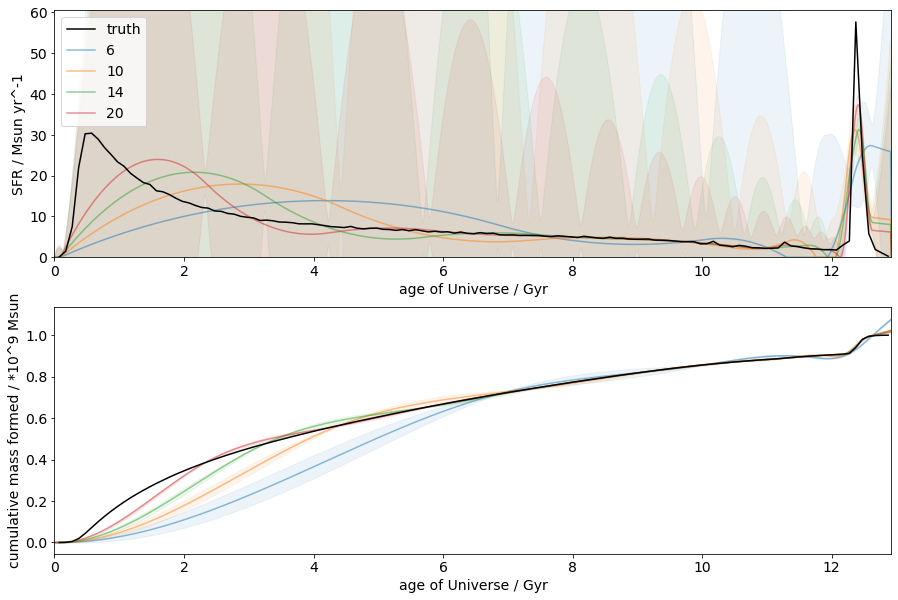

In [861]:
fig, ax = plt.subplots(2,1,figsize=[15,10])
ax[0].plot(model_ages, model_sfh, label='truth', zorder=4, color='k')
ylims = ax[0].get_ylim()
ax[1].plot(model_ages, c_model_sfh, label='truth', zorder=4, color='k')
for Nbins in [6,10,14,20]:
    tx,mf = bin_logtime(Nbins)
    lt_sfh, lt_ages, lt_c_mass, lt_sfh_var, lt_c_mass_var, lt_samples = lt_fit(Nbins, tx, mf)
    p1 = ax[0].plot(lt_ages, lt_sfh, label=Nbins, alpha=0.5)
    ax[0].fill_between(lt_ages, lt_sfh-np.sqrt(lt_sfh_var), lt_sfh+np.sqrt(lt_sfh_var), 
                  color=p1[0].get_color(), alpha=0.08)
    p2 = ax[1].plot(lt_ages, lt_c_mass, label=Nbins, alpha=0.5)
    ax[1].fill_between(lt_ages, lt_c_mass-np.sqrt(lt_c_mass_var), lt_c_mass+np.sqrt(lt_c_mass_var), 
                  color=p2[0].get_color(), alpha=0.08)
ax[0].set_xlim([0,age_at_z])
ax[0].set_ylim([0, ylims[1]])
ax[0].set_xlabel('age of Universe / Gyr')
ax[0].set_ylabel('SFR / Msun yr^-1')
ax[0].legend()
ax[1].set_xlim([0,age_at_z])
ax[1].set_xlabel('age of Universe / Gyr')
ax[1].set_ylabel('cumulative mass formed / *10^9 Msun')
plt.show()

Comments:

With this method of binning, the big starburst peak is very easily recovered with a relatively few number of bins, but the early SFH shapes are often lost. I have also added varying customizable begin and end times (in lookback times) where the bin boundaries are cut from. This means that by shrinking the end time, the bin boundaries will be more clustered to the recent bit of SFH. This shrinkage seems to help recovering the burst's shape with fewer bins.

## Testing feeding the GP log time scales instead of linear time as x axis when fitting
Currently, Iyer's sfh fitting inputs is called an SFH tuple, it includes: <br>
sfh_tuple[0] = log10 mass <br>
sfh_tuple[1] = log10 sfr at time of observation <br>
sfh_tuple[2] = number of bin boundaries <br>
sfh_tuple[3] = fractional age of the universe at z and at the percentiles which the set amount of mass have formed (i.e. the bin boundary times) <br>
<br>
The code then takes these fractions and interprets it into two lists: <br>
frac_age and frac_mass <br>
These fractions include datapoints taken at the bin boundaries (calculated as a simple division for mass quantiles for Iyer's approach, but cumulative summed thorughout the mass formed in each bin in the log time approach) and also some other important points: <br>
frac_age = 0: frac_mass = 0 <br>
frac_age = 1: frac_mass = 1 <br>
frac_age = 0.01: frac_mass = 0 (to encourage a smooth-start-to-sf SFH to be fitted) <br>
At this point, in order to ensure a smooth coupling to the observed SFR, the code injects 3 more datapoints at 97, 98 and 99 percentiles: <br>
if time required to form the last (1,2 or 3)% of mass using the recorded SFR > time remaining after final bin boundary, then <br>
frac_age = 1-fractional time needed to form the percentile of mass with recorded SFR: frac_mass = (0.97,0.98 or 0.99) <br>
else: <br>
frac_age = (0.97,0.98 or 0.99): frac_mass = fraction of mass formed during percentile\*age at observed SFR <br>
<br>
Now I modify the input times into log scale, such that it goes from 0-1 in age but bins that were originally equally spaced in linear time will now be shifted to be squished to the 0 end (early ages), potentially giving differentially more flexibility to the recent end of the SFH. <br>
The transformation is: <br>
log_time_quantiles = 1-np.log(a\*((1-linear_time_quantiles)+1)-(a-1))/np.log(a+1) <br>
(please check my maths!)
where a is a postive number that scales the base used to take the log. Larger a used will create a bigger shift in the time quantiles. <br>
<br>
After the GP fits the data, the returned time quantiles have to be un-transformed again:
linear_time_arr_interp = 1-((np.exp((1-log_time_arr_interp)\*np.log(a+1))+(a-1))/a-1)
using the same a value. <br>
<br>
Transformation effects are shown below: <br>

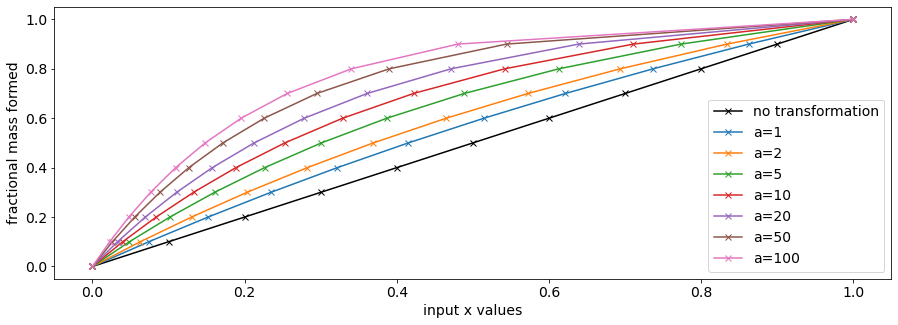

In [874]:
dem_tx = np.linspace(0,1,11)
dem_mf = np.linspace(0,1,11)

fig, ax = plt.subplots(1,1, figsize=[15,5])
ax.plot(dem_tx, dem_mf, marker='x', color='k', label='no transformation')
for i in [1,2,5,10,20,50,100]:
    dem_tx_ = 1-np.log(i*((1-dem_tx)+1)-(i-1))/np.log(i+1)
    ax.plot(dem_tx_, dem_mf, marker='x', label='a='+str(i))
ax.set_xlabel('input x values')
ax.set_ylabel('fractional mass formed')
ax.legend()
plt.show()

Now the fit:

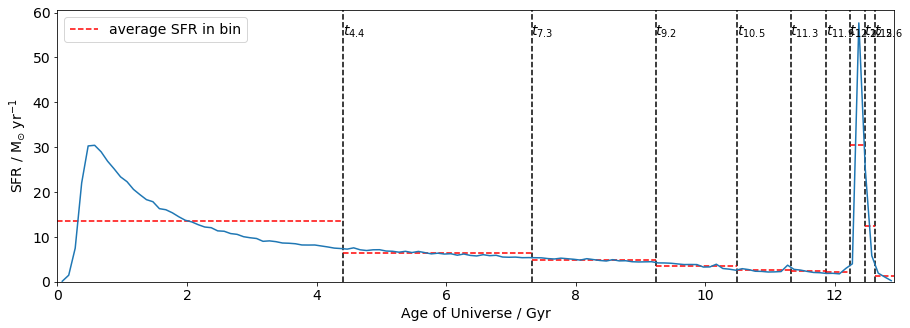

using a = 1:


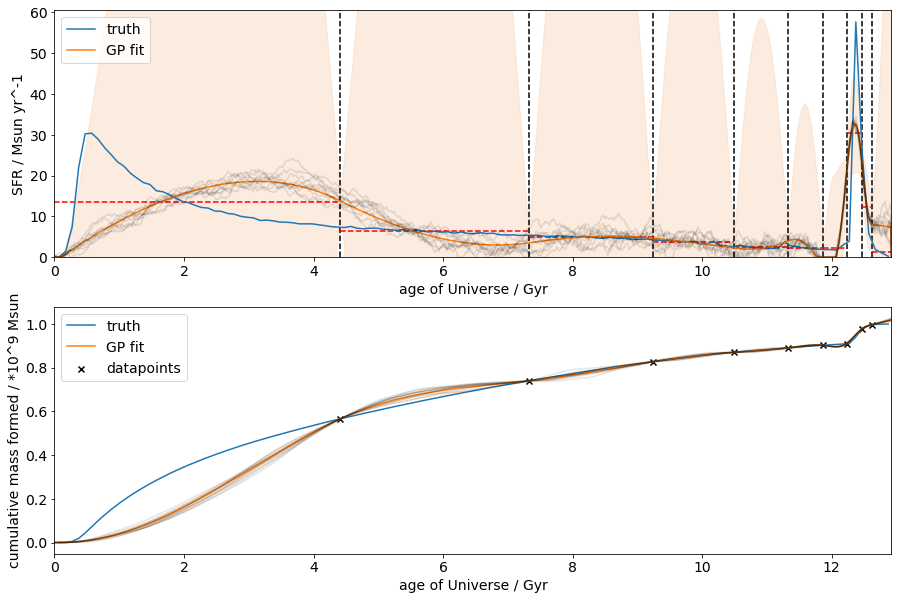

using a = 10:


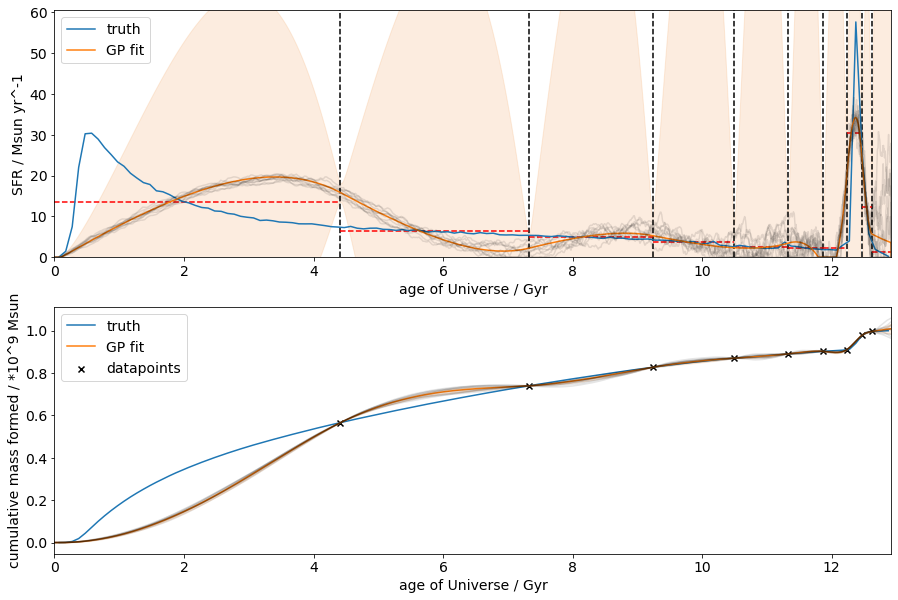

using a = 100


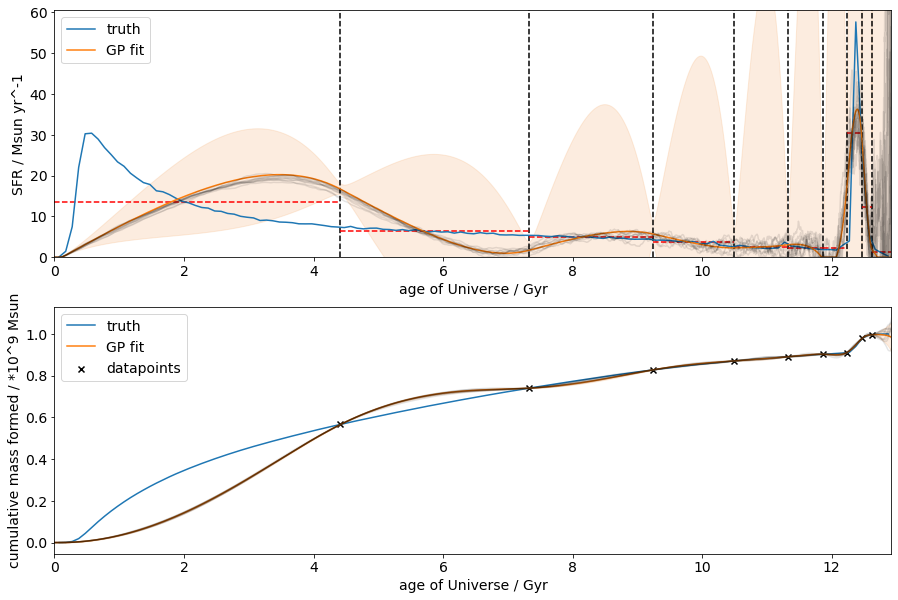

In [870]:
def fit_logtime_transform(sfh_tuple, zval, interpolator = 'gp_george', decouple_sfr = False, 
                decouple_sfr_time = 10, sfr_tolerance = 0.05, vb = False,cosmo = cosmo, a=10):
    # sfh_tuple[0] = total mass formed in log10 form
    # sfh_tuple[1] = log10 SFR at time of observation
    # sfh_tuple[2] = list of time bin boundaries in fractions of the universe's current
    # sfh_tuple[3] = list of fraction mass formed at bin boundaries
    
    # generate an SFH from an input tuple at a specified redshift
    Nparam = int(sfh_tuple[2])
    input_tx = sfh_tuple[3:3+Nparam]
    input_mf = sfh_tuple[3+Nparam:3+2*Nparam]
    c_mass_formed = np.zeros(len(input_mf))
    for i,mi in enumerate(input_mf):
        c_mass_formed[i] = np.sum(input_mf[:i+1])
    mass_quantiles = np.array([0,*c_mass_formed,1])
    time_quantiles = np.zeros_like(mass_quantiles)
    time_quantiles[-1] = 1
    time_quantiles[1:-1] = input_tx
    
    if vb == True:
        print('pre-adjustment:',time_quantiles, mass_quantiles)
    
    # now add SFR constraints
    mass_quantiles = np.insert(mass_quantiles,1,[0.00])
    time_quantiles = np.insert(time_quantiles,1,[0.01])
    
    # SFR constrained to SFR_inst at the time of observation
    #SFH_constraint_percentiles = np.array([0.96,0.97,0.98,0.99])
    SFH_constraint_percentiles = np.array([0.97, 0.98, 0.99])
    for const_vals in SFH_constraint_percentiles:

        delta_mstar = 10**(sfh_tuple[0]) *(1-const_vals)
        delta_t = 1 - delta_mstar/(10**sfh_tuple[1])/(cosmo.age(zval).value*1e9)
        if vb == True:
            print(delta_t,time_quantiles[-2])

        if (delta_t > time_quantiles[-2]) & (delta_t > 0.9):
            if vb == True:
                print('if', const_vals)
            mass_quantiles = np.insert(mass_quantiles, -1, [const_vals], )
            time_quantiles = np.insert(time_quantiles, -1, [delta_t],)
        else:
            if vb == True:
                print('else', const_vals)
            if const_vals > time_quantiles[-2]:
                delta_m = 1 - ((cosmo.age(zval).value*1e9)*(1-const_vals)*(10**sfh_tuple[1]))/(10**sfh_tuple[0])
                time_quantiles = np.insert(time_quantiles, -1, [const_vals])
                mass_quantiles=  np.insert(mass_quantiles, -1, [delta_m])
    
    #debug stuff
    if vb == True:
        print('post-adjustment:',time_quantiles, mass_quantiles)
        plt.plot(model_ages, c_model_sfh)
        plt.plot(time_quantiles*age_at_z, mass_quantiles*np.trapz(y=model_sfh, x=model_ages))
        plt.show()
        
    #transform 0-1 in linear tme to 0-1 in log lookback time
    time_quantiles_ = 1-np.log(a*((1-time_quantiles)+1)-(a-1))/np.log(a+1)
    if vb == True:
        print(time_quantiles)
        print(time_quantiles_)
    time_quantiles = time_quantiles_.copy()
    
    if interpolator == 'gp_george':
        time_arr_interp, mass_arr_interp, pred_var, mass_arr_interp_samples = gp_interpolator(
            time_quantiles, mass_quantiles, Nparam = int(Nparam), decouple_sfr = decouple_sfr, 
            var=True, sample=True)
    elif interpolator == 'gp_sklearn':
        time_arr_interp, mass_arr_interp = gp_sklearn_interpolator(time_quantiles, mass_quantiles)
    elif interpolator == 'linear':
        time_arr_interp, mass_arr_interp = linear_interpolator(time_quantiles, mass_quantiles)
    elif interpolator == 'pchip':
        time_arr_interp, mass_arr_interp = Pchip_interpolator(time_quantiles, mass_quantiles)
    else:
        raise Exception('specified interpolator does not exist: {}. \n use one of the following: gp_george, gp_sklearn, linear, and pchip '.format(interpolator))
        
    time_arr_interp_ = 1-((np.exp((1-time_arr_interp)*np.log(a+1))+(a-1))/a-1)
    if vb == True:
        print(time_arr_interp)
        print(time_arr_interp_)
    time_arr_interp = time_arr_interp_.copy()
    
    sfh, sfh_var = treat_sfh(time_arr_interp, mass_arr_interp, sfh_tuple, zval, 
                             decouple_sfr, decouple_sfr_time, sfr_tolerance, pred_var=pred_var)
    
    samp = []
    for i,sample in enumerate(mass_arr_interp_samples):
        sfh_i = treat_sfh(time_arr_interp, sample, sfh_tuple, zval, 
                             decouple_sfr, decouple_sfr_time, sfr_tolerance)
        samp.append([sfh_i, sample])

    timeax = time_arr_interp * cosmo.age(zval).value

    if vb == True:
        print('time and mass quantiles:')
        print(time_quantiles, mass_quantiles)
        plt.plot(time_quantiles, mass_quantiles,'--o')
        plt.plot(time_arr_interp, mass_arr_interp)
        plt.axis([0,1,0,1])
        #plt.axis([0.9,1.05,0.9,1.05])
        plt.show()

        print('instantaneous SFR: %.1f' %sfh[-1])
        plt.plot(np.amax(time_arr_interp) - time_arr_interp, sfh)
        #plt.xscale('log')
        plt.show()

    return sfh, timeax, mass_arr_interp, sfh_var, pred_var, samp

def lt_fit_transform(Nbins, tx, mf, a=10):
    lt_param = np.hstack([np.log10(model_Mstar), np.log10(model_sfh[-1]), Nbins-1, tx, mf])
    return fit_logtime_transform(lt_param, 0.04, vb=False, a=a)

def do_transform_lt_fit(a):
    lt_sfh, lt_ages, lt_c_mass, lt_sfh_var, lt_c_mass_var, lt_samples = lt_fit_transform(Nbins, tx, f_mass_formed, a=a)
    fig, ax = plt.subplots(2, 1, figsize=[15,10])
    ax[0].plot(model_ages, model_sfh, label='truth')
    ylims = ax[0].get_ylim()
    ax[0].vlines(tx*age_at_z, 0, ylims[1], color='k', ls='--')
    ax[0].hlines(sfrs, tx_[:-1], tx_[1:], color='r', ls='--')
    ax[0].plot(lt_ages, lt_sfh, label='GP fit')
    ax[0].fill_between(lt_ages, lt_sfh-np.sqrt(lt_sfh_var), lt_sfh+np.sqrt(lt_sfh_var), 
                      color='sandybrown', alpha=0.2)
    ax[0].set_xlim([0,age_at_z])
    ax[0].set_ylim([0,ylims[1]])
    ax[0].set_xlabel('age of Universe / Gyr')
    ax[0].set_ylabel('SFR / Msun yr^-1')
    ax[0].legend()

    ax[1].plot(model_ages, c_model_sfh, label='truth')
    ax[1].scatter(tx*age_at_z, np.cumsum(f_mass_formed), color='k', marker='x', label='datapoints')
    ax[1].plot(lt_ages, lt_c_mass, label='GP fit')
    ax[1].fill_between(lt_ages, lt_c_mass-np.sqrt(lt_c_mass_var), lt_c_mass+np.sqrt(lt_c_mass_var), 
                      color='sandybrown', alpha=0.2)
    ax[1].set_xlim([0,age_at_z])
    ax[1].set_xlabel('age of Universe / Gyr')
    ax[1].set_ylabel('cumulative mass formed / *10^9 Msun')
    for samp in lt_samples:
        ax[0].plot(lt_ages, samp[0], color='k', alpha=0.1)
        ax[1].plot(lt_ages, samp[1], color='k', alpha=0.1)
    ax[1].legend()
    plt.show()

Nbins = 10
tx, f_mass_formed = bin_logtime(Nbins, interp=True, end_time=None)
tx_ = np.array([0,*tx, 1])*age_at_z
f_mass_formed_ = np.insert(f_mass_formed, len(f_mass_formed), 1-np.sum(f_mass_formed))
durations = abs(tx_[1:] - tx_[:-1])
sfrs = f_mass_formed_*np.trapz(y=model_sfh, x=model_ages*10**9)/durations/10**9

fig, ax = plt.subplots(figsize=[15,5])
ax.plot(model_ages, model_sfh)
ax.set_xlim([0,age_at_z])
ax.set_xlabel('Age of Universe / Gyr')
ax.set_ylabel(r'SFR / $\rm{M_{\odot}}\; \rm{yr}^{-1}$')
ylims = ax.get_ylim()
ax.vlines(tx*age_at_z, 0, ylims[1], color='k', ls='--')
ax.hlines(sfrs, tx_[:-1], tx_[1:], color='r', ls='--', label='average SFR in bin')

for i,txi in enumerate(tx):
    ax.annotate('$t_{'+str(np.round(txi*age_at_z,1))+'}$', [(txi*age_at_z-0.01), 0.95*max(model_sfh)])
ax.set_ylim([0,ylims[1]])
ax.legend()
plt.show()

print('using a = 1:')
do_transform_lt_fit(1)
print('using a = 10:')
do_transform_lt_fit(10)
print('using a = 100')
do_transform_lt_fit(100)

# How about mixing the two together?
A second idea Vivienne had was to mix the two binning schemes together to get the best of both worlds. This might mean fitting for (a fewer number of) bin boundaries in both schemes, then using a unified GP-sfh reconstruction function to recreate the SFH.

## Note: here, the log time binning is restricted to divide equally in log time from 3x10^8 to the most recent bin in Iyer's scheme

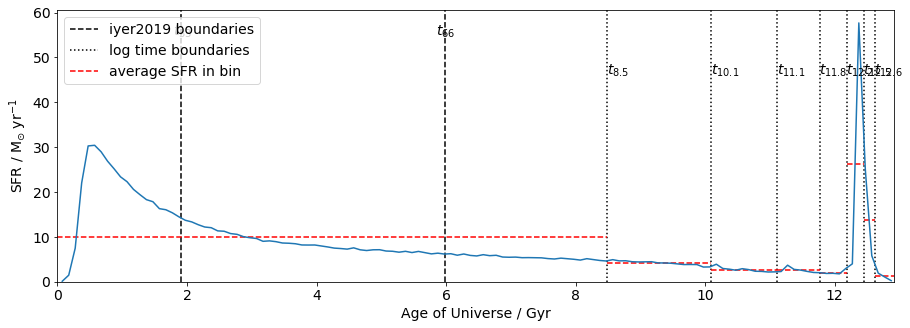

In [871]:
Nbins = [3,8]
tx_iyer = bin_iyer(Nbins[0])
tx_lt, mf_lt = bin_logtime(Nbins[1], end_time=(1-tx_iyer[-1])*age_at_z*10**9)
tx_lt_ = np.array([0,*tx_lt, 1])*age_at_z
mf_lt_ = np.insert(mf_lt, len(mf_lt), 1-np.sum(mf_lt))
durations = abs(tx_lt_[1:] - tx_lt_[:-1])
sfrs = mf_lt_*np.trapz(y=model_sfh, x=model_ages*10**9)/durations/10**9

fig, ax = plt.subplots(figsize=[15,5])
ax.plot(model_ages, model_sfh)
ax.set_xlim([0,age_at_z])
ax.set_xlabel('Age of Universe / Gyr')
ax.set_ylabel(r'SFR / $\rm{M_{\odot}}\; \rm{yr}^{-1}$')
ylims = ax.get_ylim()

ax.vlines(tx_iyer*age_at_z, 0, ylims[1], color='k', ls='--', label='iyer2019 boundaries')
for i,txi in enumerate(tx_iyer):
    ax.annotate('$t_{'+str(int((i+1)*100/Nbins[0]))+'}$', [(txi-0.01)*age_at_z, 0.95*max(model_sfh)])
ax.vlines(tx_lt*age_at_z, 0, ylims[1], color='k', ls=':', label='log time boundaries')
ax.hlines(sfrs, tx_lt_[:-1], tx_lt_[1:], color='r', ls='--', label='average SFR in bin')
for i,txi in enumerate(tx_lt):
    ax.annotate('$t_{'+str(np.round(txi*age_at_z,1))+'}$', [(txi*age_at_z-0.01), 0.8*max(model_sfh)])
    
ax.set_ylim([0,ylims[1]])
ax.legend()
plt.show()

Next, we need to combine the two bin boundary instructions into one for the fit to work

[0.14754982 0.46263317 0.65696747 0.78102237 0.86021384 0.91076636
 0.94303697 0.96363718 0.9767875 ] [0.33333333 0.33333333 0.1288998  0.06333128 0.02618212 0.01586078
 0.00801735 0.0655315  0.02211852]


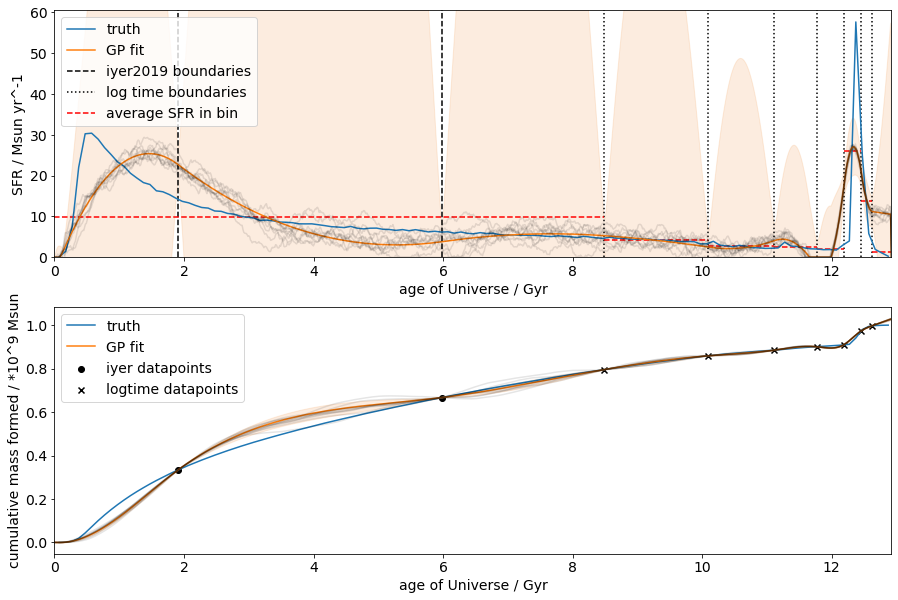

In [872]:
#converting dense_basis info into log time info
c_mf_iyer = np.arange(1,Nbins[0])/Nbins[0]
c_mf_lt = np.cumsum(mf_lt)
c_mf = np.concatenate((c_mf_iyer, c_mf_lt))
tx = np.concatenate((tx_iyer, tx_lt))
sort_ind = np.argsort(tx)
tx = tx[sort_ind]
c_mf = np.insert(c_mf[sort_ind],0,0)
mf = c_mf[1:]-c_mf[:-1]
print(tx, mf)

combine_sfh, combine_ages, combine_c_mass, combine_sfh_var, combine_c_mass_var, combine_samples = lt_fit(np.sum(Nbins)-1, tx, mf)
fig, ax = plt.subplots(2, 1, figsize=[15,10])
ax[0].plot(model_ages, model_sfh, label='truth')
ylims = ax[0].get_ylim()
ax[0].vlines(tx_iyer*age_at_z, 0, ylims[1], color='k', ls='--', label='iyer2019 boundaries')
ax[0].vlines(tx_lt*age_at_z, 0, ylims[1], color='k', ls=':', label='log time boundaries')
ax[0].hlines(sfrs, tx_lt_[:-1], tx_lt_[1:], color='r', ls='--', label='average SFR in bin')
ax[0].plot(combine_ages, combine_sfh, label='GP fit')
ax[0].fill_between(combine_ages, combine_sfh-np.sqrt(combine_sfh_var), combine_sfh+np.sqrt(combine_sfh_var), 
                  color='sandybrown', alpha=0.2)
ax[0].set_xlim([0,age_at_z])
ax[0].set_ylim([0,ylims[1]])
ax[0].set_xlabel('age of Universe / Gyr')
ax[0].set_ylabel('SFR / Msun yr^-1')
ax[0].legend()

ax[1].plot(model_ages, c_model_sfh, label='truth')
ax[1].scatter(tx_iyer*age_at_z, np.linspace(0,1,Nbins[0]+1)[1:-1], color='k', label='iyer datapoints')
ax[1].scatter(tx_lt*age_at_z, c_mf_lt, color='k', marker='x', label='logtime datapoints')
ax[1].plot(combine_ages, combine_c_mass, label='GP fit')
ax[1].fill_between(combine_ages, combine_c_mass-np.sqrt(combine_c_mass_var), combine_c_mass+np.sqrt(combine_c_mass_var), 
                  color='sandybrown', alpha=0.2)
ax[1].set_xlim([0,age_at_z])
ax[1].set_xlabel('age of Universe / Gyr')
ax[1].set_ylabel('cumulative mass formed / *10^9 Msun')
for samp in combine_samples:
    ax[0].plot(combine_ages, samp[0], color='k', alpha=0.1)
    ax[1].plot(combine_ages, samp[1], color='k', alpha=0.1)
ax[1].legend()
plt.show()

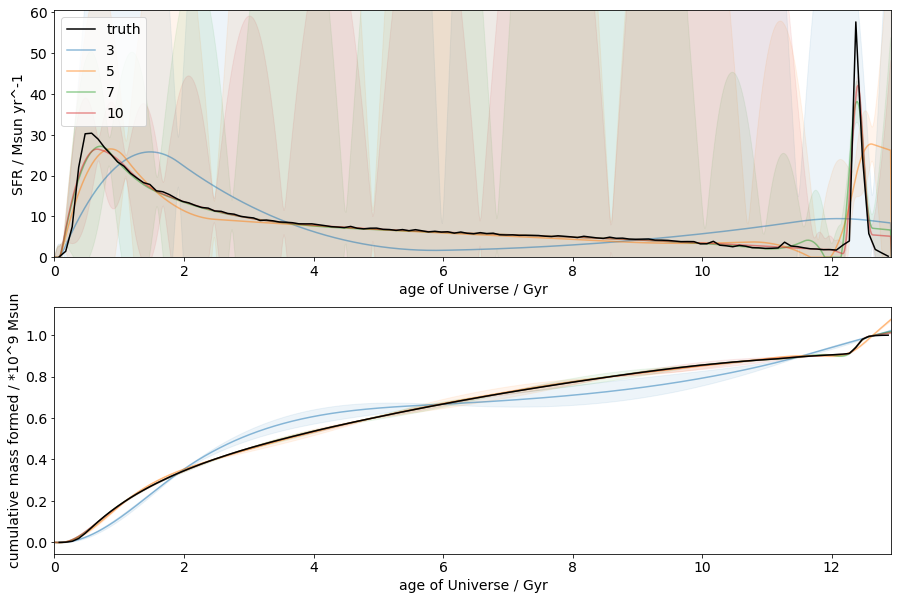

In [873]:
fig, ax = plt.subplots(2,1,figsize=[15,10])
ax[0].plot(model_ages, model_sfh, label='truth', zorder=4, color='k')
ylims = ax[0].get_ylim()
ax[1].plot(model_ages, c_model_sfh, label='truth', zorder=4, color='k')
for Nbins in [3,5,7,10]:
    tx_iyer = bin_iyer(Nbins)
    tx_lt, mf_lt = bin_logtime(Nbins, end_time=(1-tx_iyer[-1])*age_at_z*10**9)
    c_mf_iyer = np.arange(1,Nbins)/Nbins
    c_mf_lt = np.cumsum(mf_lt)
    c_mf = np.concatenate((c_mf_iyer, c_mf_lt))
    tx = np.concatenate((tx_iyer, tx_lt))
    sort_ind = np.argsort(tx)
    tx = tx[sort_ind]
    c_mf = np.insert(c_mf[sort_ind],0,0)
    mf = c_mf[1:]-c_mf[:-1]

    combine_sfh, combine_ages, combine_c_mass, combine_sfh_var, combine_c_mass_var, combine_samples = lt_fit(Nbins*2-1, tx, mf)
    p1 = ax[0].plot(combine_ages, combine_sfh, label=Nbins, alpha=0.5)
    ax[0].fill_between(combine_ages, combine_sfh-np.sqrt(combine_sfh_var), combine_sfh+np.sqrt(combine_sfh_var), 
                  color=p1[0].get_color(), alpha=0.08)
    p2 = ax[1].plot(combine_ages, combine_c_mass, label=Nbins, alpha=0.5)
    ax[1].fill_between(combine_ages, combine_c_mass-np.sqrt(combine_c_mass_var), combine_c_mass+np.sqrt(combine_c_mass_var), 
                  color=p2[0].get_color(), alpha=0.08)
ax[0].set_xlim([0,age_at_z])
ax[0].set_ylim([0, ylims[1]])
ax[0].set_xlabel('age of Universe / Gyr')
ax[0].set_ylabel('SFR / Msun yr^-1')
ax[0].legend()
ax[1].set_xlim([0,age_at_z])
ax[1].set_xlabel('age of Universe / Gyr')
ax[1].set_ylabel('cumulative mass formed / *10^9 Msun')
plt.show()

Coments: 

This seems promising. Recreation of both the early SFH behaviours and the shape of the starburst with a relatively sensible number of bins seems to be working, of course given 100% accurate placed bin boundaries (because I am directly fitting the true SFH instead of inferring those boundaries from the spectrum!). Tweaking the begin and end times of the log time binning function seems to be able to compress the number of bins needed in total to get a good recreation as well. This can be thought of telling the uniform-in-log-time bins to specialize in illistrating the shape of the starburst by giving it only the very recent bit of SFH to uniformly divide in log time, which means it requires less bins to capture the burst's SFH shape effectively with these bin boundaries. However, doing this might lose generalisability towards other types of SFHs, or even PSBs with slightly earlier starbursts (e.g. if t_burst is before the set end_time?).

In order for this mixed scheme to work in Bagpipes, the two binning schemes' relevent parameters will probably have to be sampled seperately. Iyer's parameters will be the bin boundaries (tx) under one dirichlet distribution, and the log time binning will be the fractional mass formed in each bin under another dirichlet distribution. Then a function combines the two schemes together and uses a GP to fit for the SFH.

# Experimenting with various begin and end times on combined binning

## Note: the following is experimental purpose, still lacking in documentation

end time set as None


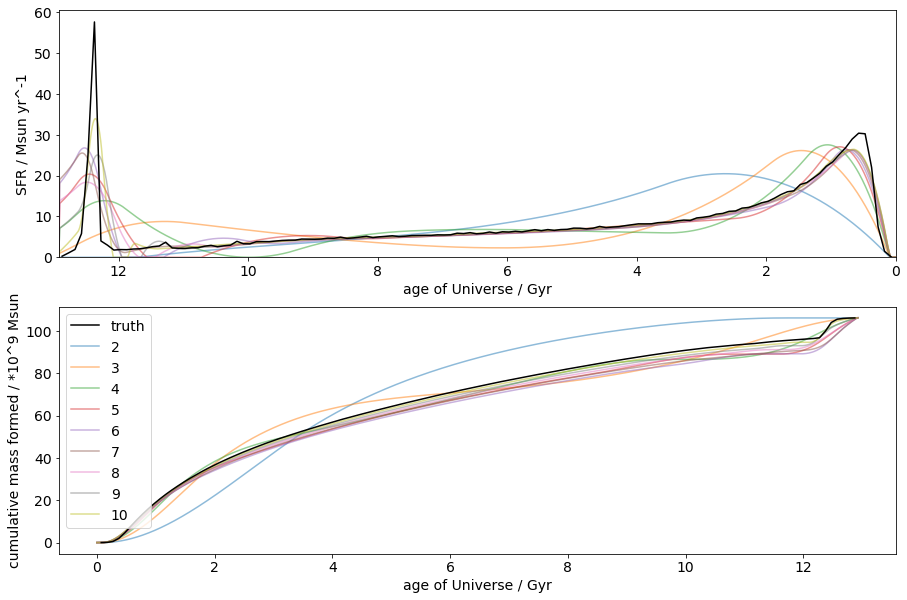

end time set as 5000000000


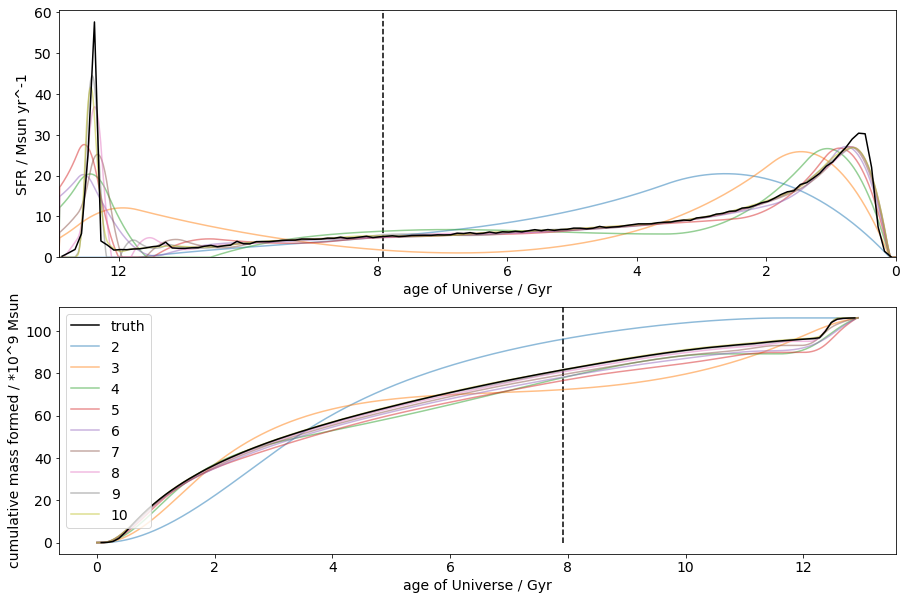

end time set as 3000000000


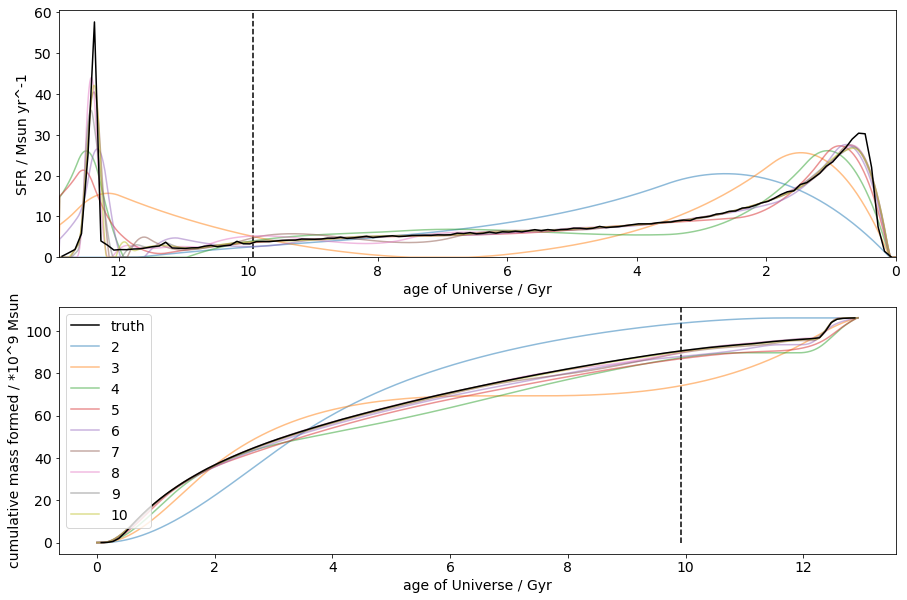

end time set as 2000000000


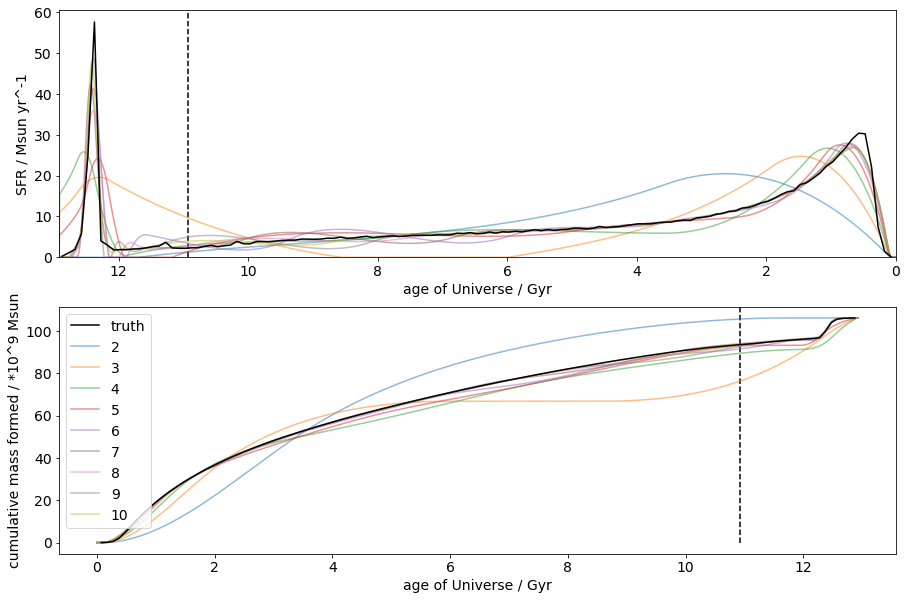

end time set as 1500000000.0


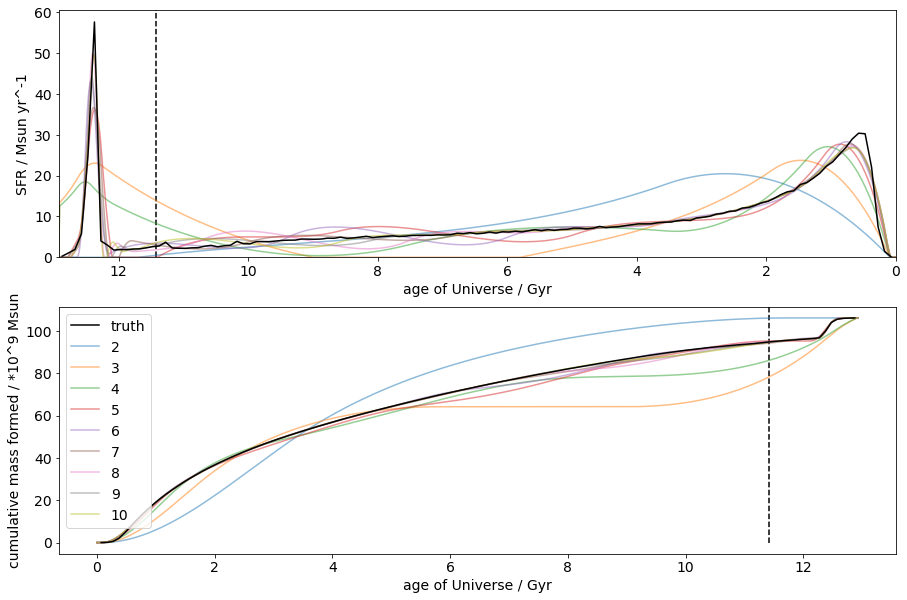

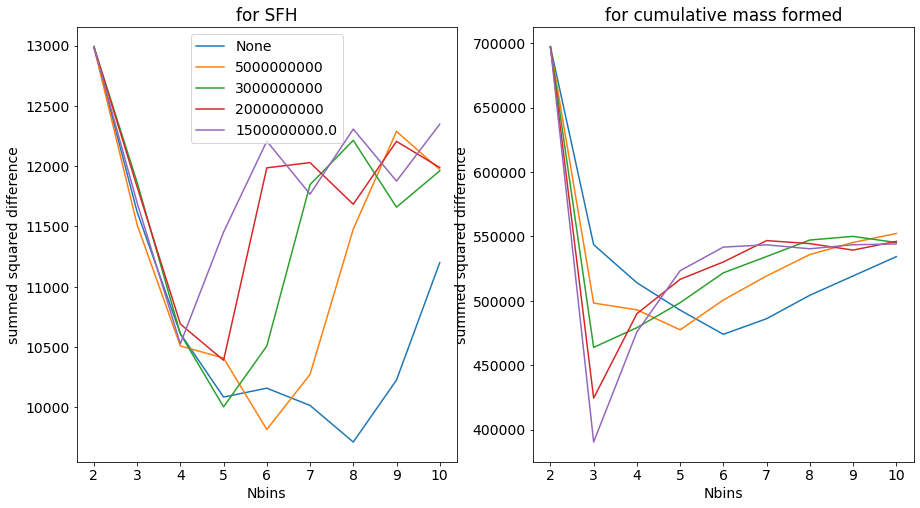

In [599]:
def cal_diff(model, fit):
    #take the y values of the fit at equivilent x values to the model's x values
    interp_fit_y = np.interp(model[0], fit[0], fit[1])
    return np.sum((interp_fit_y-model[0])**2)

diffs = [[],[]]
end_times = [None, 5*10**9, 3*10**9, 2*10**9, 1.5*10**9]
for end_time in end_times:
    print('end time set as', end_time)
    fig, ax = plt.subplots(2,1,figsize=[15,10])
    ax[0].plot(model_ages, model_sfh, label='truth', zorder=4, color='k')
    ax[1].plot(model_ages, c_model_sfh, label='truth', zorder=4, color='k')
    ylims = [ax[0].get_ylim(), ax[1].get_ylim()]
    if end_time is not None:
        ax[0].vlines(age_at_z-end_time/10**9, 0, ylims[0][1], color='k', ls='--')
        ax[1].vlines(age_at_z-end_time/10**9, 0, ylims[1][1], color='k', ls='--')
    sfh_diff = []
    c_mass_diff = []
    for Nbins in [2,3,4,5,6,7,8,9,10]:
        tx_iyer = bin_iyer(Nbins)
        tx_lt, mf_lt = bin_logtime(Nbins, end_time=end_time)
        c_mf_iyer = np.arange(1,Nbins)/Nbins
        c_mf_lt = np.cumsum(mf_lt)
        c_mf = np.concatenate((c_mf_iyer, c_mf_lt))
        tx = np.concatenate((tx_iyer, tx_lt))
        sort_ind = np.argsort(tx)
        tx = tx[sort_ind]
        c_mf = np.insert(c_mf[sort_ind],0,0)
        mf = c_mf[1:]-c_mf[:-1]

        combine_ages, combine_sfh= lt_fit(2*Nbins-1, tx, mf)
        sfh_diff.append(cal_diff([model_ages, model_sfh],[combine_ages, combine_sfh]))
        ax[0].plot(combine_ages, combine_sfh, label=Nbins, alpha=0.5)

        c_combine_sfh = np.zeros(len(combine_ages))
        for i,sfh in enumerate(combine_sfh):
            c_combine_sfh[i] = np.trapz(combine_sfh[:i+1],x=combine_ages[:i+1])
        c_mass_diff.append(cal_diff([model_ages, c_model_sfh],[combine_ages, c_combine_sfh]))
        ax[1].plot(lt_ages, c_combine_sfh, label=Nbins, alpha=0.5)
    diffs[0].append(sfh_diff)
    diffs[1].append(c_mass_diff)
    ax[0].set_xlim([age_at_z,0])
    ax[0].set_ylim([0,ylims[0][1]])
    ax[0].set_xlabel('age of Universe / Gyr')
    ax[0].set_ylabel('SFR / Msun yr^-1')
    ax[1].legend()
    ax[1].set_ylim(ylims[1])
    ax[1].set_xlabel('age of Universe / Gyr')
    ax[1].set_ylabel('cumulative mass formed / *10^9 Msun')
    plt.show()
fig, ax = plt.subplots(1,2,figsize=[15,8])
for i,end_time in enumerate(end_times):
    ax[0].plot([2,3,4,5,6,7,8,9,10], diffs[0][i], label=str(end_time))
    ax[1].plot([2,3,4,5,6,7,8,9,10], diffs[1][i], label=str(end_time))
ax[0].legend()
ax[0].set_title('for SFH')
ax[0].set_xlabel('Nbins')
ax[0].set_ylabel('summed squared difference')
ax[1].set_title('for cumulative mass formed')
ax[1].set_xlabel('Nbins')
ax[1].set_ylabel('summed squared difference')
plt.show()